# Vertex Cover

### Definition

We are given an undirected graph with vertex set $V$ and edge set $E$.

Our aim is to find the smallest number of nodes to be coloured, such that every edge has a coloured vertex. Also, which vertices would these be? 

### Applications

The Vertex Cover has applications in matching problems and optimization problems in fields like Biochemistry, Computational Biology, Monitoring and Computer Network Security.

### Path to solving the problem
Vertex Cover is a minimization problem and its cost function can be cast to a QUBO problem through its respective Hamiltonian (see the [Introduction](./introduction_combinatorial_optimization.ipynb) and a [reference](https://arxiv.org/abs/1302.5843)),

$$ \displaystyle \large
H = A \textstyle\sum\limits_{uv \in E}  (1 - x_u) (1 - x_v) + B \textstyle\sum\limits_{v} x_v
$$

where $A$ and $B$ are positive constants, $u, v \in V$ and $x_u$ is a binary variable, which is $1$ if vertex $u$ is part of the Vertex Cover and $0$ if it is not. For a valid encoding, the $A$ and $B$ constants need to obey the relation $A > B$. 
Otherwise, if this rule is not followed, the spin configuration for the lowest energy $H$ may not correspond to the best solution of our Vertex Cover problem or even to a valid one. At the same time $A \gg B$ would not be desired, as it would cause a large energy separation in $H$, impeding our solution approach.

The QLM allows us to encode a problem in this Hamiltonian form by using the `VertexCover` class for a given graph and constants $A$ and $B$. We can then create a job from the problem and send it to a heuristic Simulated Quantum Annealer (SQA) wrapped inside a Quantum Processing Unit (QPU) like the rest of the QPUs on the QLM. The SQA will minimize $H$, hence find the best solution to our problem.

For a more detailed explanation and a step-by-step guidance, please follow the sections below.

### Quantum complexity

To represent the problem as QUBO the QLM would need $N$ spins $-$ to encode each of the $N$ vertices. 

# Example problem

Imagine we are given a graph with $6$ vertices and $6$ edges, as shown below (left). The solution of this problem is quite easy to guess $-$ we can simply colour node $0$ and either node $1$ or node $5$ (right).

<br><img src="./vertex_cover_example_solution.png" style="width: 850px"><br>

However, let's describe a method, which will enable us to find the Vertex Cover of any graph!

We shall start by specifying a graph with the `networkx` library along with the constants $A$ and $B$.

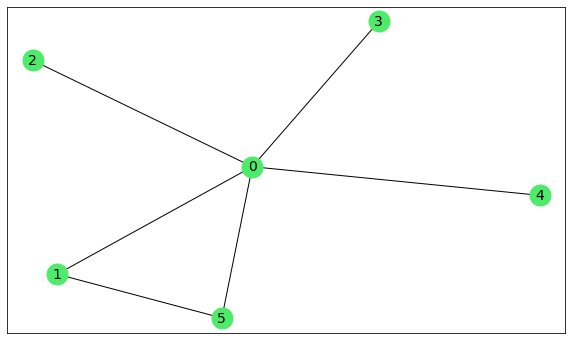

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Specify the graph 
# First example
graph = nx.Graph()
graph.add_nodes_from(np.arange(6))
graph.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5)])

# # Second example
# graph = nx.gnm_random_graph(15, 30)

# Impose constraints for the right encoding
B = 1
A = B + 1

# Draw the graph
nodes_positions = nx.spring_layout(graph, iterations=len(graph.nodes())*60)
plt.figure(figsize=(10, 6))
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=440, 
                 font_size=14)
plt.show()

Once the graph is specified and the constants $A$ and $B$ correctly chosen, we can encode the problem via our `VertexCover` class:

In [2]:
from qat.opt import VertexCover

vertex_cover_problem = VertexCover(graph, A=A, B=B)

# Solution

Once an instance of the problem is created, we can proceed to compute the solution of the problem by following the steps:

1. Extract the best SQA parameters found for Vertex Cover by calling the method `get_best_parameters()`.

    The number of Monte Carlo updates is the total number of updates performed for each temperature (and gamma) on the spins of the equivalent 2D classical system. These updates are the product of the number of annealing steps $-$ `n_steps`, the number of "Trotter replicas" $-$ `n_trotters`, and the problem size, i.e. the number of qubits needed. Hence, we can use these parameters to get the best inferred value for `n_steps`. In general, the more these steps are, the finer and better the annealing will be. However this will cause the process to take longer to complete.
    
    Similarly for the `n_trotters` field in `SQAQPU` $-$ the higher it is, the better the final solution could be, but the more time taken by the annealer to reach an answer.


2. Create a temperature and a gamma schedule for the annealing.

    We use the extracted max and min temperatures and gammas to create a (linear) temperature and a (linear) gamma schedule. These schedules evolve in time from higher to lower values since we simulate the reduction of temperatures and magnetic fields. If one wishes to vary them it may help if the min values are close to $0$, as this will cause the Hamiltonian to reach a lower energy state, potentially closer to its ground state (where the solution is encoded).

    It should be noted that non-linear schedules may be investigated too, but for the same number of steps they could lead to a slower annealing. The best min and max values for gamma and the temperature were found for linear schedules.


3. Generate the SQAQPU and create a job for the problem. The job is then sent to the QPU and the annealing is performed.


4. Present the solution spin configuration and a list of the respective coloured vertices.


5. Show the graph with the coloured nodes.

Each spin from the solution configuration corresponds to a node from the graph at the same position. Note that if the numbering of the input nodes starts from $1$ and not from $0$, one still needs to look at the $0$th spin to extract information for this first node, numbered as $1$.

Solution configuration: 
[ 1.  1. -1. -1. -1. -1.]

One would need to colour 2 vertices, which are:
[0 1]



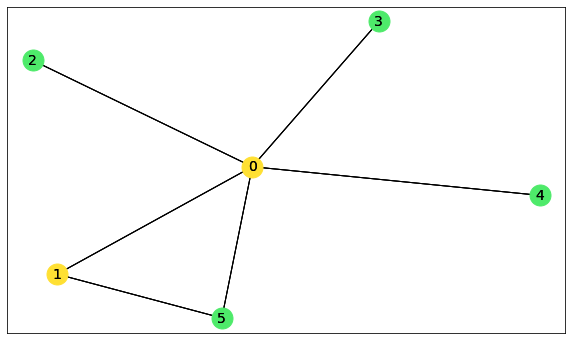

In [3]:
from qat.core import Variable
from qat.sqa import SQAQPU
from qat.sqa.sqa_qpu import integer_to_spins

# 1. Extract parameters for SQA
problem_parameters_dict = vertex_cover_problem.get_best_parameters()
n_monte_carlo_updates = problem_parameters_dict["n_monte_carlo_updates"]
n_trotters = problem_parameters_dict["n_trotters"]
n_steps = int(n_monte_carlo_updates /
              (n_trotters * len(graph.nodes()))) # the last one is the number of spins, i.e. the problem size
temp_max = problem_parameters_dict["temp_max"]
temp_min = problem_parameters_dict["temp_min"]
gamma_max = problem_parameters_dict["gamma_max"]
gamma_min = problem_parameters_dict["gamma_min"]

# 2. Create a temperature and a gamma schedule
tmax = 1.0
t = Variable("t", float)
temp_t = temp_min * (t / tmax) + temp_max * (1 - t / tmax)
gamma_t = gamma_min * (t / tmax) + gamma_max * (1 - t / tmax)

# 3. Create a job and send it to a QPU
problem_job = vertex_cover_problem.to_job(gamma_t=gamma_t, tmax=tmax, nbshots=1)
sqa_qpu = SQAQPU(temp_t=temp_t, n_steps=n_steps, n_trotters=n_trotters)
problem_result = sqa_qpu.submit(problem_job)

# 4. Present best configuration
state_int = problem_result.raw_data[0].state.int  # raw_data is a list of Samples - one per shot
solution_configuration = integer_to_spins(state_int, len(graph.nodes()))
print("Solution configuration: \n" + str(solution_configuration) + "\n")
indices_spin_1 = np.where(solution_configuration == 1)[0]
number_of_colours = len(indices_spin_1)
print("One would need to colour " + "\033[1m" + str(number_of_colours) + 
      "\033[0;0m" + " vertices, which are:\n" + str(indices_spin_1) + "\n")

# 5. Show the coloured graph
plt.figure(figsize=(10, 6))
node_size = 440
font_size = 14
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_1.tolist(), 
                 node_color='#FFE033', 
                 node_size=node_size, 
                 font_size=font_size)

indices_spin_minus_1 = np.where(solution_configuration == -1)[0]
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_minus_1.tolist(), 
                 node_color='#4EEA6A', 
                 node_size=node_size, 
                 font_size=font_size)
nx.draw_networkx_edges(graph, pos=nodes_positions)
plt.show()

# Solution analysis

For graphs which are quite big, one may find it hard to examine visually the solution. Therefore, here is a simple check for this purpose $-$ whether each edge has a coloured vertex and if not $-$ a list of colourless edges.

In [4]:
colourless_edges_list = []
for (node_i, node_j) in graph.edges():
    if node_i not in indices_spin_1 and node_j not in indices_spin_1:
        colourless_edges_list.append((node_i, node_j))
if len(colourless_edges_list) == 0:
    print ("The graph is covered well !")
else:
    print("The " + "\033[1m" + str(len(colourless_edges_list)) + 
          "\033[0;0m" + " edges without coloured nodes are:")
    print("(node, node)")
    for edge in colourless_edges_list: print(edge)

The graph is covered well !
